In [1]:
import numpy as np
import autograd.numpy as anp

# Model parameters
γ = 10.
ρ = 1.5
β = np.exp(-0.005)
a = 0.0355
ϕ_1 = 0.0125
ϕ_2 = 400.
α_k = 0.025
U_k = np.array([1,0])
σ_k = np.array([0.477,0,0]) * 0.01
A = np.array([[np.exp(-0.014),0],[0,np.exp(-0.0022)]])
B = np.array([[0.011,0.025,0],[0,0,0.119]]) * 0.01

args = (γ, ρ, β, a, ϕ_1, ϕ_2, α_k, U_k, σ_k, A, B)

def eq_cond_no_habit(X_t, X_tp1, W_tp1, q, *args):
    # Parameters for the model
    γ, ρ, β, a, ϕ_1, ϕ_2, α_k, U_k, σ_k, A, B = args

    # Variables in X_t:
    # log V_t/C_t, log R_t/C_t,
    # log C_t/K_t, log I_t/K_t,
    # log (K_{t}/K_{t-1}), Z_{1,t}, Z_{2,t}
    vmc_t, rmc_t, cmk_t, imk_t, gk_t, z1_t, z2_t = X_t.ravel()
    vmc_tp1, rmc_tp1, cmk_tp1, imk_tp1, gk_tp1, z1_tp1, z2_tp1 = X_tp1.ravel()

    # Exogenous states
    Z_t = anp.array([z1_t, z2_t])
    Z_tp1 = anp.array([z1_tp1, z2_tp1])
    # Stochastic depreciation, capital growth and log ψ
    g_dep = -α_k + U_k.T@Z_t + σ_k.T@W_tp1
    log_ψ = anp.log(ϕ_1*ϕ_2) + (ϕ_1-1)*anp.log(1+ϕ_2*anp.exp(imk_t)) + g_dep
    # log SDF, excluding the change of measure
    sdf_ex = anp.log(β) + (ρ-1)*(vmc_tp1+cmk_tp1+gk_tp1-cmk_t-rmc_t) - ρ*(cmk_tp1+gk_tp1-cmk_t)

    # Marginals and pricing kernel
    mk_tp1 = vmc_tp1+cmk_tp1
    mc_tp1 = anp.log(1-β) + ρ*(vmc_tp1)
    log_Q = sdf_ex + mk_tp1 - mc_tp1

    # Eq0: Change of measure evaluated at γ=0
    m = vmc_tp1 + cmk_tp1 + gk_tp1 - cmk_t - rmc_t
    # Eq1: Recursive utility
    res_1 = (1-β) + β*anp.exp((1-ρ)*(rmc_t)) - anp.exp((1-ρ)*(vmc_t))
    # Eq2: FOC for consumption/investment
    res_2 = anp.exp(log_Q + log_ψ)
    # Eq3: Investment ratio
    res_3 = a - anp.exp(cmk_t) - anp.exp(imk_t)
    # Eq4: capital
    res_4 = gk_tp1 - ϕ_1 * anp.log(1+ϕ_2*anp.exp(imk_t)) - g_dep
    # Eq5-6: State process
    res_5 = (A@Z_t + B@W_tp1 - Z_tp1)[0]
    res_6 = (A@Z_t + B@W_tp1 - Z_tp1)[1]

    return anp.array([m, res_1,res_2,res_3,res_4,res_5, res_6])

In [2]:
from scipy import optimize

def ss_func_no_habit(*args):
    # Extra parameters for the model
    γ, ρ, β, a, ϕ_1, ϕ_2, α_k, U_k, σ_k, A, B = args

    # Optimize over c_t-k_t
    def f(cmk):
        # Level investment
        I = a - np.exp(cmk)
        # Capital growth
        g_k = ϕ_1 * np.log(1 + ϕ_2 * I) - α_k
        # Set growth rate to capital growth
        η = g_k
        # Increment in capital induced by a marginal decrease in consumption
        log_ψ =  np.log(ϕ_1) + np.log(ϕ_2) + (ϕ_1-1)*np.log(1 + ϕ_2 * I) - α_k
        # v
        vmc = (np.log(1-β) - np.log(1-β*np.exp((1-ρ)*η)))/(1-ρ)
        # sdf, note that sdf_c = sdf_u in steady states
        sdf = np.log(β) - ρ*η
        # log_Q
        mk_next = vmc+cmk
        mc_next = np.log(1-β) + ρ*vmc
        log_Q = mk_next - mc_next + sdf
        return np.exp(log_Q + log_ψ) - 1

    # Find roots
    cmk_star = optimize.bisect(f,-40,np.log(a))
    cmk = cmk_star

    # Calculate steady states
    z_1 = 0.
    z_2 = 0.
    Z = np.array([z_1,z_2])
    I = a - np.exp(cmk)
    g_k = ϕ_1 * np.log(1 + ϕ_2 * I) - α_k
    η = g_k
    
    # c, k, h, u, sdf, v, r, mu, mh, mc, imk
    vmc = (np.log(1-β) - np.log(1-β*np.exp((1-ρ)*η)))/(1-ρ)
    rmc = vmc + η
    imk = np.log(a - np.exp(cmk))

    X_0 = np.array([vmc,rmc,cmk,imk,g_k,z_1,z_2])
    return X_0

In [3]:
from expansion import recursive_expansion

modelSol = recursive_expansion(eq_cond=eq_cond_no_habit,
                               ss=ss_func_no_habit,
                               var_shape=(4,3,3),
                               γ=args[0],
                               second_order=False,
                               args=args)
X_tp1 = modelSol.X_tp1

/var/folders/jc/9v589bkn7l71jxtqk_7k35l00000gp/T/ipykernel_69745/2167222835.py:18: RuntimeWarning: invalid value encountered in log
  vmc = (np.log(1-β) - np.log(1-β*np.exp((1-ρ)*η)))/(1-ρ)
/opt/anaconda3/lib/python3.8/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [4]:
np.set_printoptions(precision=6,suppress=True)
modelSol.X1_tp1.coeffs # First order LOM coefficients

{'w': array([[ 0.004005,  0.009103,  0.      ],
        [ 0.004032,  0.009165,  0.      ],
        [ 0.001305,  0.002966,  0.      ],
        [-0.000792, -0.001799,  0.      ],
        [ 0.00477 ,  0.      ,  0.      ],
        [ 0.00011 ,  0.00025 ,  0.      ],
        [ 0.      ,  0.      ,  0.00119 ]]),
 'c': array([[-0.123193],
        [-0.124033],
        [-0.04014 ],
        [ 0.024351],
        [ 0.000273],
        [ 0.      ],
        [ 0.      ]]),
 'x': array([[-0.      , 35.904646,  0.      ],
        [-0.      , 36.149241,  0.      ],
        [-0.      , 11.698877,  0.      ],
        [ 0.      , -7.097123,  0.      ],
        [-0.      ,  0.91918 ,  0.      ],
        [ 0.      ,  0.986098,  0.      ],
        [ 0.      ,  0.      ,  0.997802]])}

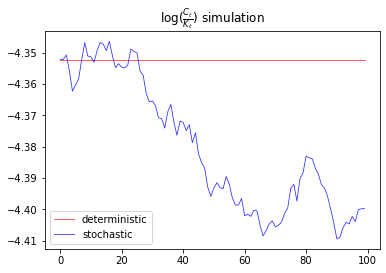

In [5]:
T = 100 # time horizon for simulation
_, _, n_W = modelSol.var_shape # the number of shocks within this model
Ws_1 = np.zeros((T,n_W)) # "generate" zero shocks throughout the horizon T=100
sim_result_1 = modelSol.simulate(Ws_1) # feed the generated shocks to the simulate method

Ws_2 = np.random.multivariate_normal(np.zeros(n_W), np.eye(n_W), size = T) # generate N(0,I) shocks
sim_result_2 = modelSol.simulate(Ws_2) # feed the generated shocks to the simulate method

import matplotlib.pyplot as plt
# sim_result contains the simulated value of all model variables over the specified horizon
# recall that we arranged log(C_t/K_t) as the 3rd jump variable, and python index starts from 0
plt.plot(sim_result_1[:,2], 'r', lw = .8, alpha = .8, label = 'deterministic') 
plt.plot(sim_result_2[:,2], 'b', lw = .8, alpha = .8, label = 'stochastic')
plt.legend()
plt.title(r'$\log(\frac{C_t}{K_t})$ simulation')
plt.show()

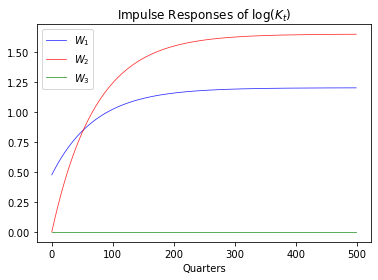

In [6]:
states_IRF = []
jumps_IRF = []
T = 500 # time horizon for IRF computation
for shock_index in [0,1,2]: # we have three shocks for this model
    states, jumps = modelSol.IRF(T, shock_index)
    states_IRF.append(states)
    jumps_IRF.append(jumps)

plt.plot(np.cumsum(states_IRF[0][:,0])*100, color='b', lw=0.8, alpha=0.8, label = "$W_1$")
plt.plot(np.cumsum(states_IRF[1][:,0])*100, color='r', lw=0.8, alpha=0.8, label = "$W_2$")
plt.plot(np.cumsum(states_IRF[2][:,0])*100, color='g', lw=0.8, alpha=0.8, label = "$W_3$")
plt.legend()
plt.xlabel("Quarters")
plt.title("Impulse Responses of $\log(K_t)$")
# plt.savefig("IncomeIRF", dpi = 300)
plt.show()

In [7]:
def log_SDF_ex_no_habit(X_t, X_tp1, W_tp1, q, *args):
    γ, ρ, β, a, ϕ_1, ϕ_2, α_k, U_k, σ_k, A, B = args
    
    vmc_t, rmc_t, cmk_t, imk_t, gk_t, z1_t, z2_t = X_t.ravel()
    vmc_tp1, rmc_tp1, cmk_tp1, imk_tp1, gk_tp1, z1_tp1, z2_tp1 = X_tp1.ravel()

    sdf_ex = anp.log(β) + (ρ-1)*(vmc_tp1+cmk_tp1+gk_tp1-cmk_t-rmc_t) - ρ*(cmk_tp1+gk_tp1-cmk_t)
    
    return sdf_ex

In [8]:
log_SDF = modelSol.approximate_fun(log_SDF_ex_no_habit, args) + modelSol.log_M

/opt/anaconda3/lib/python3.8/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [9]:
X_growth = modelSol.X_tp1 - modelSol.X_t
X_growth_list = X_growth.split()
CmK_growth = X_growth_list[2]
K_growth = modelSol.X_tp1.split()[4]
C_growth = CmK_growth + K_growth

In [10]:
from elasticity import price_elasticity, exposure_elasticity
price = price_elasticity(C_growth, 
                         log_SDF,
                         modelSol.Z1_tp1,
                         None,
                         400,
                         0,
                         0.4)

exposure = exposure_elasticity(C_growth, 
                         modelSol.Z1_tp1,
                         None,
                         400,
                         0,
                         0.4)

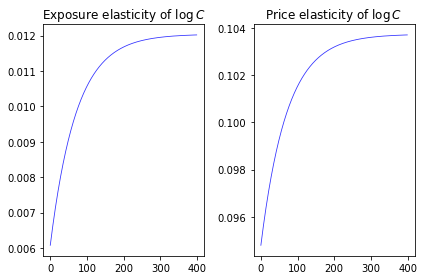

In [11]:
fig, axs = plt.subplots(1,2)
axs[0].plot(exposure, color='b', lw=0.8, alpha=0.8)
axs[0].set_title('Exposure elasticity of $\log C$')
axs[1].plot(price, color='b', lw=0.8, alpha=0.8)
axs[1].set_title('Price elasticity of $\log C$')
plt.tight_layout()
plt.show()